In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("serl_daily_energy_use_in_gb_domestic_buildings_2020_to_2023_aggregated_statistics.csv")

In [5]:
df.columns

Index(['quantity', 'unit', 'summary_time', 'aggregation_period',
       'weekday_weekend', 'segmentation_variable_1', 'segment_1_value',
       'segmentation_variable_2', 'segment_2_value', 'segmentation_variable_3',
       'segment_3_value', 'mean', 'standard_deviation', 'standard_error_mean',
       'median', '25th_percentile', '75th_percentile', 'mean_temp', 'mean_hdd',
       'mean_solar', 'n_rounded'],
      dtype='object')

In [6]:
df_ev_pv = df[
    (df["segment_1_value"] == "Gas") &                   # Filter for gas-heated homes
    (df["summary_time"] == "Daily") &                    # Daily summaries only
    (df["segmentation_variable_3"] == "has_ev")          # Segmenting by EV ownership
].copy()

In [7]:
print(df_ev_pv["segment_2_value"].unique())  # PV ownership
print(df_ev_pv["segment_3_value"].unique())  # EV ownership

['Yes' 'No' 'All']
['No' 'Yes' 'No data']


In [8]:
def assign_group(row):
    pv = row["segment_2_value"]
    ev = row["segment_3_value"]
    if pv == "No" and ev == "No":
        return "No PV / No EV"
    elif pv == "Yes" and ev == "No":
        return "PV Only"
    elif pv == "No" and ev == "Yes":
        return "EV Only"
    elif pv == "Yes" and ev == "Yes":
        return "PV + EV"
    else:
        return "Other"

df_ev_pv["ownership_group"] = df_ev_pv.apply(assign_group, axis=1)

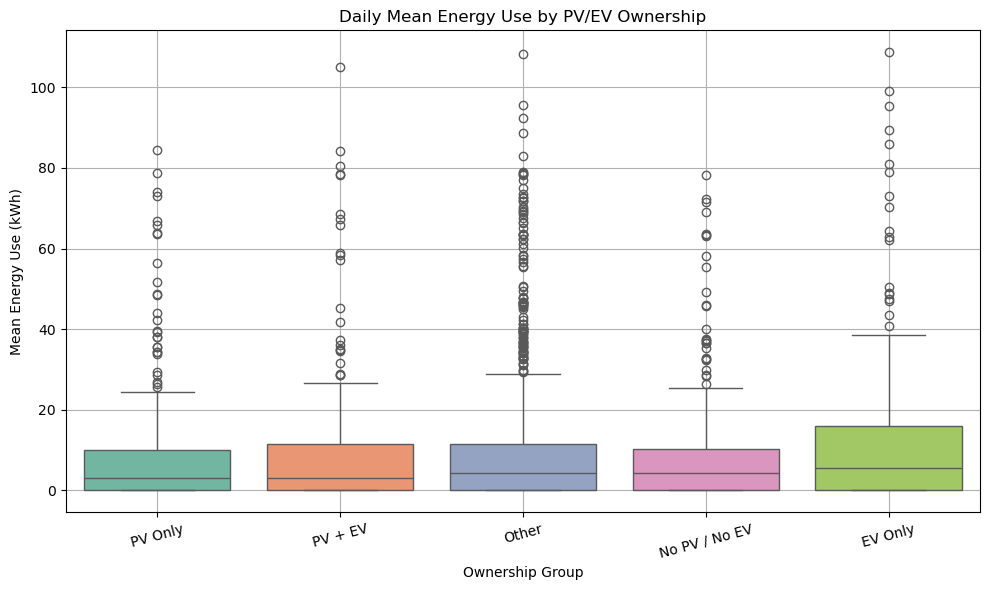

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_ev_pv, 
    x="ownership_group", 
    y="mean", 
    hue="ownership_group",   # explicitly assign hue
    palette="Set2",
    legend=False             # suppress duplicate legend
)
plt.title("Daily Mean Energy Use by PV/EV Ownership")
plt.ylabel("Mean Energy Use (kWh)")
plt.xlabel("Ownership Group")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()

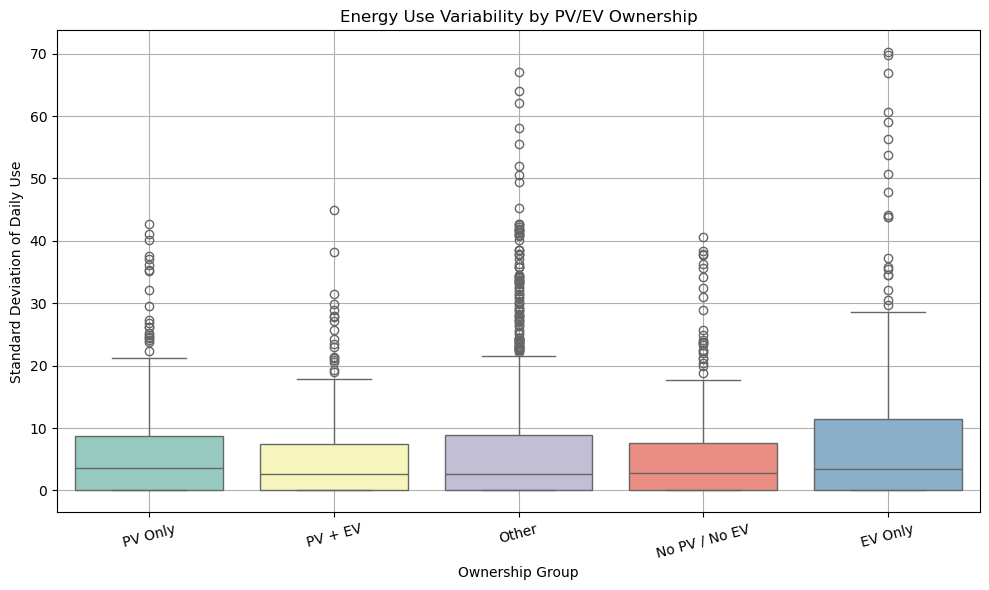

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_ev_pv, 
    x="ownership_group", 
    y="standard_deviation", 
    hue="ownership_group",   # explicitly assign hue
    palette="Set3", 
    legend=False             # remove extra legend
)
plt.title("Energy Use Variability by PV/EV Ownership")
plt.ylabel("Standard Deviation of Daily Use")
plt.xlabel("Ownership Group")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [12]:
group_means = df_ev_pv.groupby("ownership_group")["mean"].mean().sort_values(ascending=False)
print(group_means)

ownership_group
EV Only          13.311063
Other            10.847953
PV + EV          10.644094
PV Only          10.184999
No PV / No EV    10.093801
Name: mean, dtype: float64


In [13]:
group_stdevs = df_ev_pv.groupby("ownership_group")["mean"].std().sort_values(ascending=False)
print(group_stdevs)

ownership_group
EV Only          21.347773
PV + EV          18.805927
Other            17.671917
PV Only          17.299398
No PV / No EV    16.370710
Name: mean, dtype: float64


In [14]:
group_summary = df_ev_pv.groupby("ownership_group")["mean"].agg(['mean', 'std']).rename(
    columns={"mean": "Mean Energy Use (kWh)", "std": "Std Dev (kWh)"}
).sort_values(by="Mean Energy Use (kWh)", ascending=False)

print(group_summary)

                 Mean Energy Use (kWh)  Std Dev (kWh)
ownership_group                                      
EV Only                      13.311063      21.347773
Other                        10.847953      17.671917
PV + EV                      10.644094      18.805927
PV Only                      10.184999      17.299398
No PV / No EV                10.093801      16.370710


In [15]:
from tabulate import tabulate

# Generate the summary table
group_summary = df_ev_pv.groupby("ownership_group")["mean"].agg(['mean', 'std']).rename(
    columns={"mean": "Mean Energy Use (kWh)", "std": "Std Dev (kWh)"}
).sort_values(by="Mean Energy Use (kWh)", ascending=False).round(2)

# Print with tabulate
print(tabulate(group_summary, headers='keys', tablefmt='grid'))

+-------------------+-------------------------+-----------------+
| ownership_group   |   Mean Energy Use (kWh) |   Std Dev (kWh) |
+===================+=========================+=================+
| EV Only           |                   13.31 |           21.35 |
+-------------------+-------------------------+-----------------+
| Other             |                   10.85 |           17.67 |
+-------------------+-------------------------+-----------------+
| PV + EV           |                   10.64 |           18.81 |
+-------------------+-------------------------+-----------------+
| PV Only           |                   10.18 |           17.3  |
+-------------------+-------------------------+-----------------+
| No PV / No EV     |                   10.09 |           16.37 |
+-------------------+-------------------------+-----------------+


The results show that the EV Only group has the highest mean energy use, while the PV Only group has the lowest mean energy use. EV only has the largest variability (standard deviation) of any group, while No PV / No EV has the lowest variability.

In [16]:
df_ev_pv["standard_deviation"] = pd.to_numeric(df_ev_pv["standard_deviation"], errors='coerce')
df_var = df_ev_pv.dropna(subset=["standard_deviation", "ownership_group"])

In [17]:
import scipy.stats as stats

grouped_var = df_var.groupby("ownership_group")["standard_deviation"]
groups_var_data = [group for name, group in grouped_var if group.shape[0] > 0]

f_stat_var, p_val_var = stats.f_oneway(*groups_var_data)

print(f"ANOVA for Variability - F-statistic: {f_stat_var:.4f}")
print(f"P-value: {p_val_var:.4f}")

ANOVA for Variability - F-statistic: 3.0450
P-value: 0.0163


ANOVA tells us if there a significant difference in energy use variability between any groups. Since the P-value is less than 0.05, there is significant difference between the groups. The Tukey HSD test tells us which pairs of groups have statistically significant differences in energy use variability.

In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_var = pairwise_tukeyhsd(
    endog=df_var["standard_deviation"],
    groups=df_var["ownership_group"],
    alpha=0.05
)

print(tukey_var.summary())

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
      EV Only No PV / No EV  -3.1053 0.0465 -6.1809 -0.0297   True
      EV Only         Other  -2.0615 0.1383 -4.4857  0.3627  False
      EV Only       PV + EV  -3.6487 0.0133 -6.7877 -0.5097   True
      EV Only       PV Only  -2.4409 0.1927 -5.5165  0.6347  False
No PV / No EV         Other   1.0438 0.7652 -1.3804   3.468  False
No PV / No EV       PV + EV  -0.5434 0.9898 -3.6824  2.5956  False
No PV / No EV       PV Only   0.6644 0.9766 -2.4112    3.74  False
        Other       PV + EV  -1.5872 0.4151 -4.0914  0.9169  False
        Other       PV Only  -0.3794  0.993 -2.8036  2.0448  False
      PV + EV       PV Only   1.2078 0.8315 -1.9312  4.3468  False
------------------------------------------------------------------


Several significant differences found:
- EV Only households had higher variability than PV Only and No PV / No EV
- PV + EV also had higher variability than PV Only

Finding	Interpretation
 - EV ownership increases both energy use and variability.	Likely due to EV charging, which is irregular and energy-intensive
- PV ownership does not significantly reduce mean energy use (in net terms).	Possibly because this is net usage (solar offsets visible only in daytime), or consumption stays high
- Homes with both PV and EV show high variability.	Suggests dynamic patterns (charging + generation)
- "Other" group behaves inconsistently.	Possibly a mixed or misclassified group — treat with caution

In [19]:
# Ensure 'mean' is numeric
df_ev_pv["mean"] = pd.to_numeric(df_ev_pv["mean"], errors="coerce")

# Drop rows with missing values in relevant columns
df_mean = df_ev_pv.dropna(subset=["mean", "ownership_group"])

In [20]:
grouped_mean = df_mean.groupby("ownership_group")["mean"]
groups_mean_data = [group for name, group in grouped_mean if group.shape[0] > 0]

# Run ANOVA
f_stat, p_val = stats.f_oneway(*groups_mean_data)
print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4f}")

ANOVA F-statistic: 1.0446
P-value: 0.3828


In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_mean = pairwise_tukeyhsd(
    endog=df_mean["mean"],
    groups=df_mean["ownership_group"],
    alpha=0.05
)

# Print raw summary
print(tukey_mean.summary())

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
      EV Only No PV / No EV  -3.2173 0.4006 -8.2241 1.7895  False
      EV Only         Other  -2.4631 0.4314 -6.4095 1.4833  False
      EV Only       PV + EV   -2.667 0.6113  -7.777 2.4431  False
      EV Only       PV Only  -3.1261  0.431 -8.1329 1.8807  False
No PV / No EV         Other   0.7542 0.9852 -3.1922 4.7005  False
No PV / No EV       PV + EV   0.5503 0.9984 -4.5597 5.6603  False
No PV / No EV       PV Only   0.0912    1.0 -4.9156  5.098  False
        Other       PV + EV  -0.2039 0.9999 -4.2804 3.8727  False
        Other       PV Only   -0.663 0.9909 -4.6093 3.2834  False
      PV + EV       PV Only  -0.4591 0.9992 -5.5691 4.6509  False
-----------------------------------------------------------------


In [22]:
#start PCA now

In [23]:
features = [
    "mean",                # Average daily energy use
    "standard_deviation",  # Usage variability
    "mean_temp",           # Avg temperature
    "mean_hdd",            # Heating degree days
    "mean_solar"           # Solar irradiance
]

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
# Ensure all features are numeric
for col in features:
    df_ev_pv[col] = pd.to_numeric(df_ev_pv[col], errors='coerce')

# Drop missing values
df_pca = df_ev_pv.dropna(subset=features + ["ownership_group"]).copy()

# Extract X (features) and scale
X = df_pca[features]
X_scaled = StandardScaler().fit_transform(X)

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA scores to DataFrame
df_pca["PC1"] = X_pca[:, 0]
df_pca["PC2"] = X_pca[:, 1]


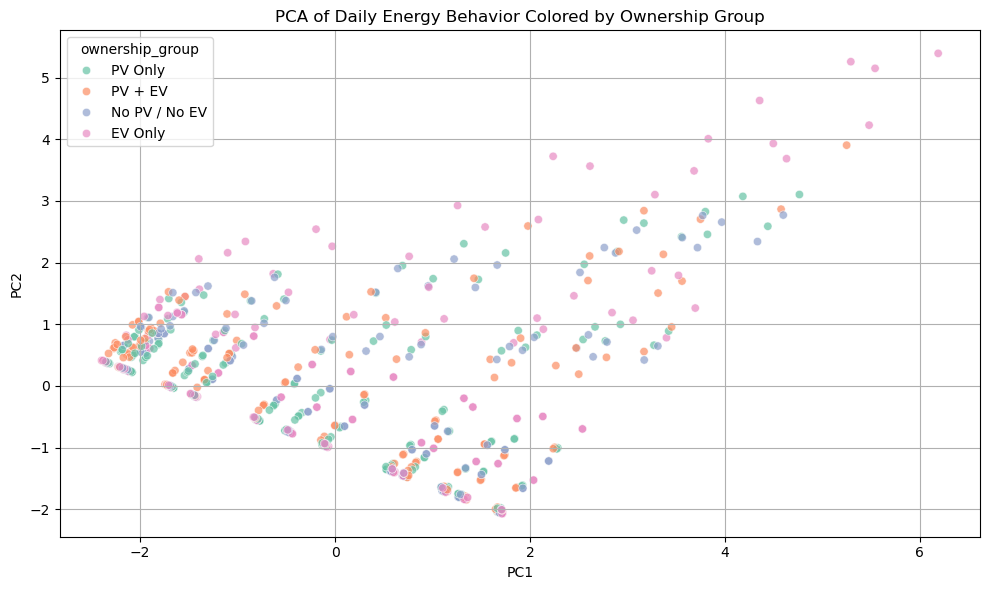

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pca_no_other = df_pca[df_pca["ownership_group"] != "Other"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca_no_other, x="PC1", y="PC2", hue="ownership_group", palette="Set2", alpha=0.7)
plt.title("PCA of Daily Energy Behavior Colored by Ownership Group")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.59862427 0.32161665]


In [29]:
pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=['PC1', 'PC2']
).round(2)

,PC1,PC2
mean,0.37,0.60
standard_deviation,0.36,0.61
mean_temp,-0.51,0.31
mean_hdd,0.51,-0.31
mean_solar,-0.45,0.27


In [30]:
df_pca.groupby("ownership_group")[["PC1", "PC2"]].mean().round(2)

,PC1,PC2
ownership_group,,
EV Only,0.13,0.19
No PV / No EV,-0.04,-0.09
Other,0.00,0.00
PV + EV,-0.09,-0.07
PV Only,-0.02,-0.04


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [32]:
df_pca_filtered = df_pca[df_pca["ownership_group"] != "Other"].copy()

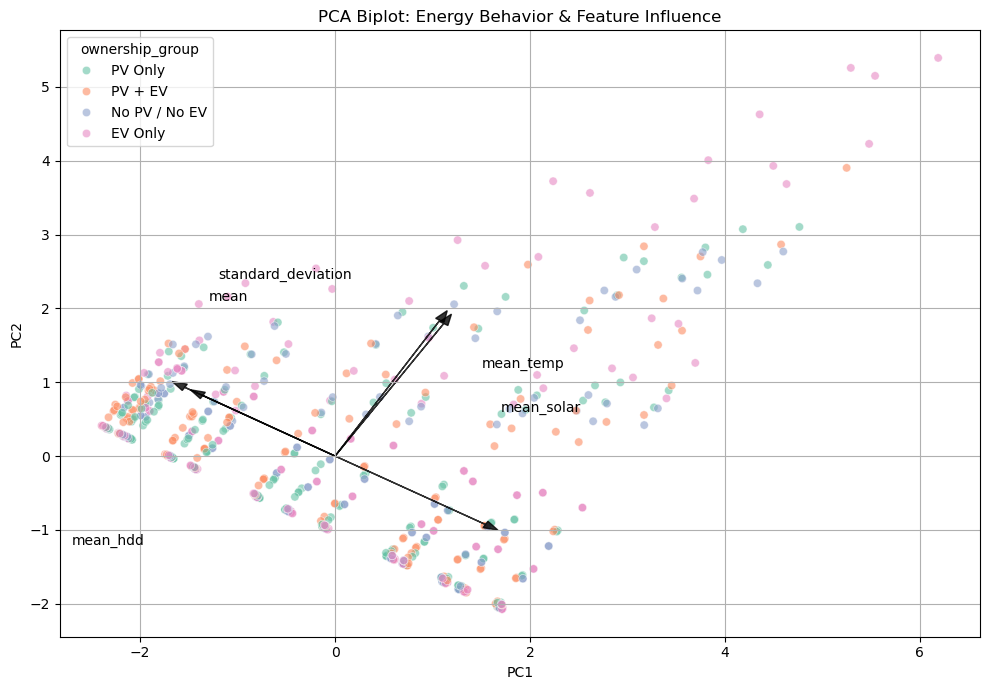

In [33]:
# Get the loadings
loadings = pca.components_.T  # shape: (n_features, n_components)

# Scale loadings for better display (optional tweak)
scaling_factor = 3  # You can adjust this to fit the arrows better

plt.figure(figsize=(10, 7))

# Plot PCA points (scores)
sns.scatterplot(data=df_pca_filtered, x="PC1", y="PC2", hue="ownership_group", alpha=0.6, palette="Set2")

# Define custom label positions manually for clarity
custom_label_positions = {
    "mean": (-1.3, 2.1),
    "standard_deviation": (-1.2, 2.4),
    "mean_temp": (1.5, 1.2),
    "mean_hdd": (-2.7, -1.2),
    "mean_solar": (1.7, 0.6)
}

# Plot feature vectors
for i, feature in enumerate(features):
    x = loadings[i, 0] * scaling_factor
    y = loadings[i, 1] * scaling_factor
    plt.arrow(0, 0, x, y, color='black', alpha=0.8, head_width=0.1)

    # Use custom positions for labels
    label_x, label_y = custom_label_positions[feature]
    plt.text(label_x, label_y, feature, color='black', fontsize=10)

"""
# Plot feature vectors (loadings)
for i, feature in enumerate(features):
    plt.arrow(0, 0, 
              loadings[i, 0] * scaling_factor, 
              loadings[i, 1] * scaling_factor,
              color='black', alpha=0.8, head_width=0.1)
    plt.text(loadings[i, 0] * scaling_factor * 1.15, 
             loadings[i, 1] * scaling_factor * 1.15, 
             feature, color='black', fontsize=10)
"""
plt.title("PCA Biplot: Energy Behavior & Feature Influence")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
from sklearn.cluster import KMeans

# Use filtered PCA data (excluding 'Other')
X_cluster = df_pca_filtered[["PC1", "PC2"]]

# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

# Add cluster labels to DataFrame
df_pca_filtered["cluster"] = clusters


C:\Miniconda3\envs\_scripting310w_2025\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


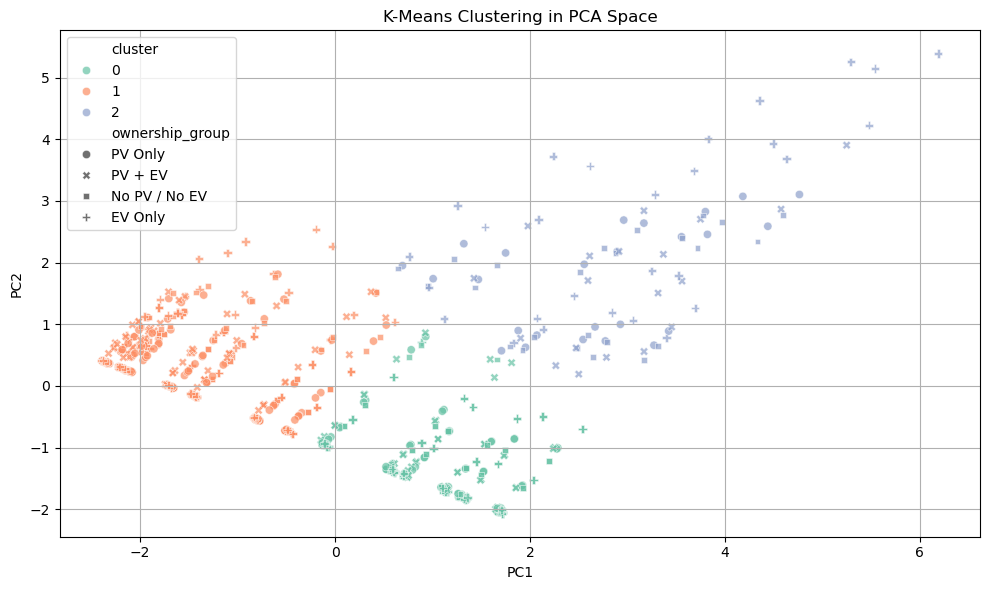

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pca_filtered,
    x="PC1", y="PC2",
    hue="cluster",
    palette="Set2",
    style="ownership_group",
    alpha=0.7
)
plt.title("K-Means Clustering in PCA Space")
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
pd.crosstab(df_pca_filtered["cluster"], df_pca_filtered["ownership_group"], normalize='index')

ownership_group,EV Only,No PV / No EV,PV + EV,PV Only
cluster,,,,
0,0.245421,0.252747,0.252747,0.249084
1,0.252525,0.257576,0.232323,0.257576
2,0.291667,0.250000,0.197917,0.260417


In [37]:
df_pca_filtered.groupby("cluster")[["mean", "standard_deviation", "mean_temp", "mean_hdd", "mean_solar"]].mean().round(2)

,mean,standard_deviation,mean_temp,mean_hdd,mean_solar
cluster,,,,,
0,4.31,3.00,7.64,7.85,56.85
1,5.56,4.19,14.03,2.75,187.79
2,53.01,31.47,7.71,7.84,66.12


In [38]:
print(df_pca_filtered.columns)

Index(['quantity', 'unit', 'summary_time', 'aggregation_period',
       'weekday_weekend', 'segmentation_variable_1', 'segment_1_value',
       'segmentation_variable_2', 'segment_2_value', 'segmentation_variable_3',
       'segment_3_value', 'mean', 'standard_deviation', 'standard_error_mean',
       'median', '25th_percentile', '75th_percentile', 'mean_temp', 'mean_hdd',
       'mean_solar', 'n_rounded', 'ownership_group', 'PC1', 'PC2', 'cluster'],
      dtype='object')


In [39]:
"""
+-----------------------------+
| SERL Aggregated Statistics |
|  (2020–2023, Daily Data)   |
+-------------+--------------+
              |
              v
+------------------------------+
| Filter by:                  |
| - Daily summaries           |
| - Gas heating               |
| - PV & EV segmentation      |
+-------------+--------------+
              |
              v
+------------------------------+
| Select relevant features:   |
| - mean, std, temp, HDD, solar|
| - Remove missing values      |
| - Standardise data           |
+-------------+--------------+
              |
              v
+------------------------------+
| Statistical Testing          |
| - ANOVA                     |
| - Tukey HSD (post-hoc)      |
+-------------+--------------+
              |
              v
+------------------------------+
| Exploratory Analysis         |
| - Principal Component Analysis|
| - K-Means Clustering         |
+------------------------------+
"""

'\n+-----------------------------+\n| SERL Aggregated Statistics |\n|  (2020–2023, Daily Data)   |\n+-------------+--------------+\n              |\n              v\n+------------------------------+\n| Filter by:                  |\n| - Daily summaries           |\n| - Gas heating               |\n| - PV & EV segmentation      |\n+-------------+--------------+\n              |\n              v\n+------------------------------+\n| Select relevant features:   |\n| - mean, std, temp, HDD, solar|\n| - Remove missing values      |\n| - Standardise data           |\n+-------------+--------------+\n              |\n              v\n+------------------------------+\n| Statistical Testing          |\n| - ANOVA                     |\n| - Tukey HSD (post-hoc)      |\n+-------------+--------------+\n              |\n              v\n+------------------------------+\n| Exploratory Analysis         |\n| - Principal Component Analysis|\n| - K-Means Clustering         |\n+-----------------------------